以下のパラメータでシミュレーションを実行して、hopG >= 2 の場合は、協力が進化しないことを確認する。hopG = 1 の場合については、hopG_1.ipynb で確認する。
```julia
# ../data/20220617_161330/*.csv
# simulation_pattern: 6480
trial_count = 50
agent_count = 10^3
generations = 10^4

network_type_list = [:scale_free_4, :regular_4, :random_4]  # [:scale_free_4, :regular_4, :random_4]
hop_game_list = [1, 2, 3, 4, 5, 6]  # [1, 2, 3, 4, 5, 6]
hop_learning_list = [1, 2, 3, 4, 5, 6]  # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b_list = [3.0, 4.0, 5.0, 6.0, 7.0]  # [4.0, 4.5, 5.0, 5.5, 6.0]
μ_list = [0.0]  # [0.0, 0.01]
δ_list = [0.1, 1.0]  # [0.0625, 0.125, 0.25, 0.5, 1.0]
interaction_rule_list = [PairWise, Group]  # [PairWise, Group]
update_rule_list = [BD, DB, IM]  # [BD, DB, IM]
```

In [1]:
import glob
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set(font_scale = 1.0, style = 'darkgrid')

In [2]:
COLUMNS = {
    'network_type': str,
    'hop_game': int,
    'hop_learning': int,
    'b': float,
    'μ': float,
    'δ': float,
    'interaction_rule': str,
    'update_rule': str,
    'trial': int,
    'step': int,
    'cooperator_rate': float
}
GROUPBY_COLUMNS = [c for c in COLUMNS if c not in ['trial', 'step', 'cooperator_rate']]

def load_df(csv_file_name: str) -> pd.DataFrame:
    _df = pd.read_csv(csv_file_name, header=None, names=COLUMNS.keys(), dtype=COLUMNS)
    return _df[_df.step >= 8000].groupby(GROUPBY_COLUMNS).agg({'cooperator_rate': np.mean}).reset_index()

In [3]:
%%time
# Load
dir_name = '20220617_195718'

file_list = glob.glob('../../data/{}/*.csv'.format(dir_name))
print(len(file_list))

df_list = [load_df(file) for file in file_list]
df = pd.concat(df_list).groupby(GROUPBY_COLUMNS).agg({'cooperator_rate': np.mean}).reset_index()
df

50
CPU times: user 40.6 s, sys: 1.29 s, total: 41.9 s
Wall time: 41.9 s


,network_type,hop_game,hop_learning,b,μ,δ,interaction_rule,update_rule,cooperator_rate
0,random_4,1,1,3.0,0.0,0.1,Group,BD,0.000065
1,random_4,1,1,3.0,0.0,0.1,Group,DB,0.000000
2,random_4,1,1,3.0,0.0,0.1,Group,IM,0.000200
3,random_4,1,1,3.0,0.0,0.1,PairWise,BD,0.000434
4,random_4,1,1,3.0,0.0,0.1,PairWise,DB,0.000000
...,...,...,...,...,...,...,...,...,...
6475,scale_free_4,6,6,7.0,0.0,1.0,Group,DB,0.000000
6476,scale_free_4,6,6,7.0,0.0,1.0,Group,IM,0.000000
6477,scale_free_4,6,6,7.0,0.0,1.0,PairWise,BD,0.000000
6478,scale_free_4,6,6,7.0,0.0,1.0,PairWise,DB,0.000000


以下で、Group interaction かつ (DB or IM) 更新の場合にのみ、協力が進化しうることが確認できる。

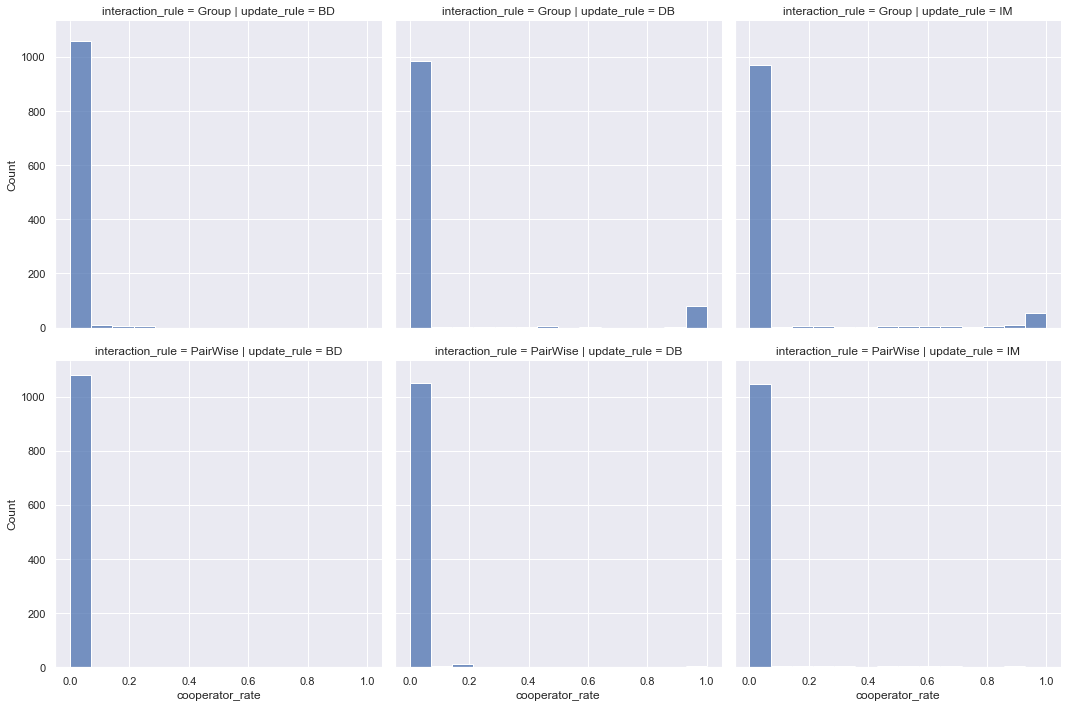

In [4]:
sns.displot(df, x='cooperator_rate', col='update_rule', row='interaction_rule')

In [5]:
df1 = df[(df.interaction_rule == 'Group') & (df.update_rule.isin(['DB', 'IM']))][[
    'network_type',
    'hop_game',
    'hop_learning',
    'b',
    'δ',
    'update_rule',
    'cooperator_rate'
]]
df1

,network_type,hop_game,hop_learning,b,δ,update_rule,cooperator_rate
1,random_4,1,1,3.0,0.1,DB,0.0000
2,random_4,1,1,3.0,0.1,IM,0.0002
7,random_4,1,1,3.0,1.0,DB,0.0000
8,random_4,1,1,3.0,1.0,IM,0.0000
13,random_4,1,1,4.0,0.1,DB,0.0000
...,...,...,...,...,...,...,...
6464,scale_free_4,6,6,6.0,1.0,IM,0.0000
6469,scale_free_4,6,6,7.0,0.1,DB,0.0000
6470,scale_free_4,6,6,7.0,0.1,IM,0.0000
6475,scale_free_4,6,6,7.0,1.0,DB,0.0000


以下で、`hopG == 1` の場合にのみ、協力が進化しうることが確認できる。

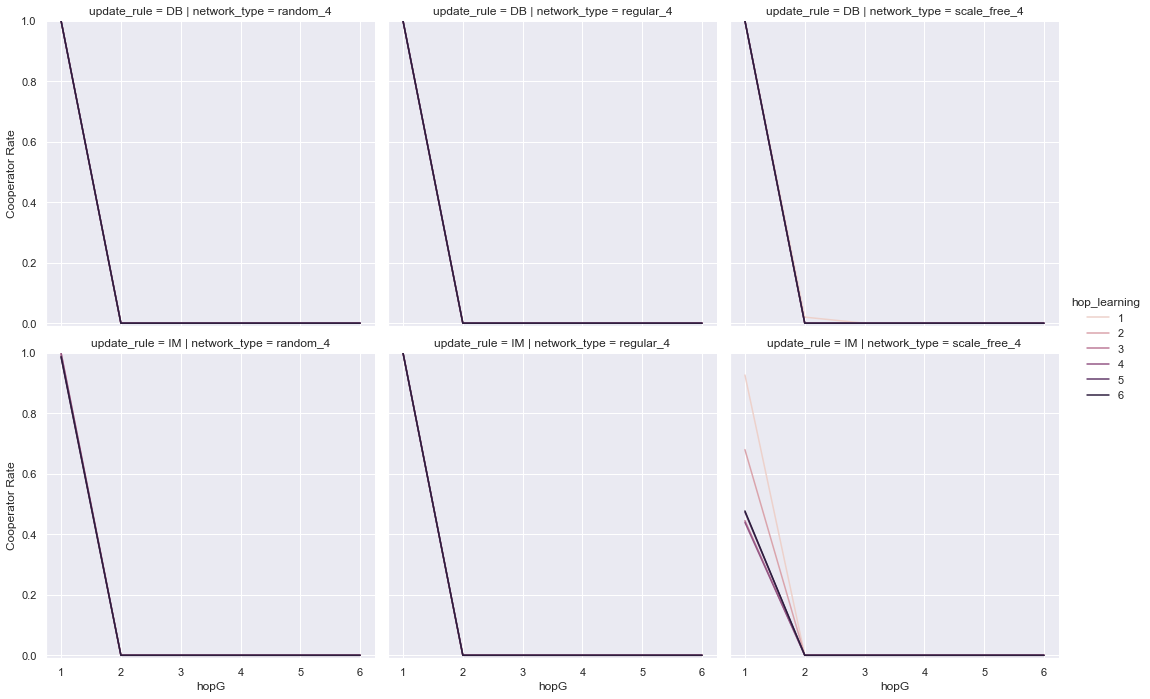

In [6]:
df2 = df1[(df1.δ == 1.0) & (df1.b == 6.0)][[
    'network_type',
    'hop_game',
    'hop_learning',
    'update_rule',
    'cooperator_rate'
]].reset_index(drop=True)
df2

g = sns.relplot(kind='line', x='hop_game', y='cooperator_rate', hue='hop_learning', row='update_rule', col='network_type', data=df2)
g.set_axis_labels('hopG', 'Cooperator Rate')
g.fig.subplots_adjust(top=.95)
g.set(ylim=(-0.01, 1))

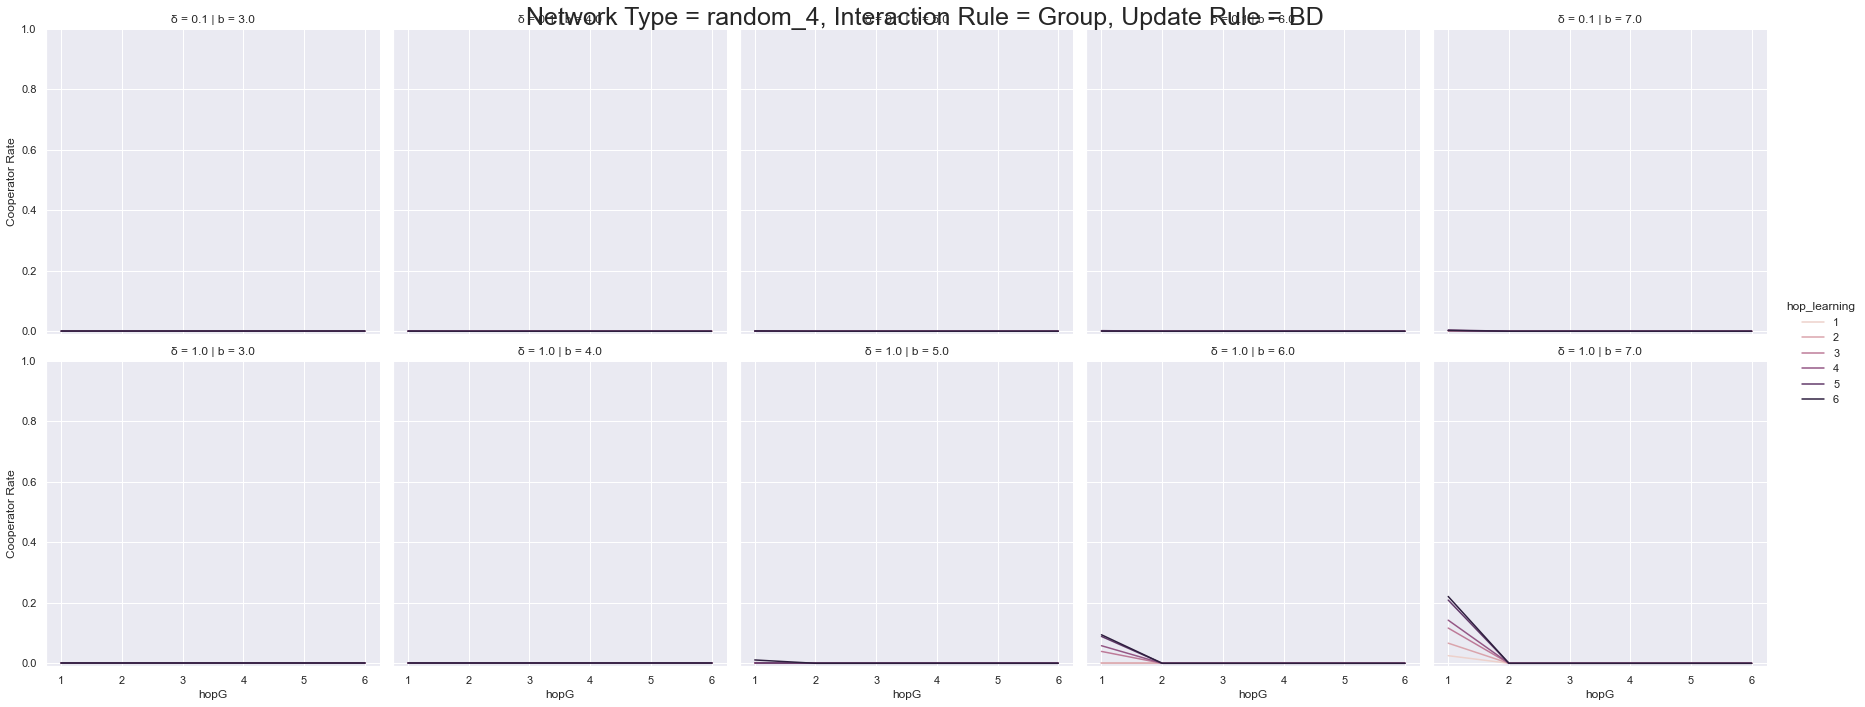

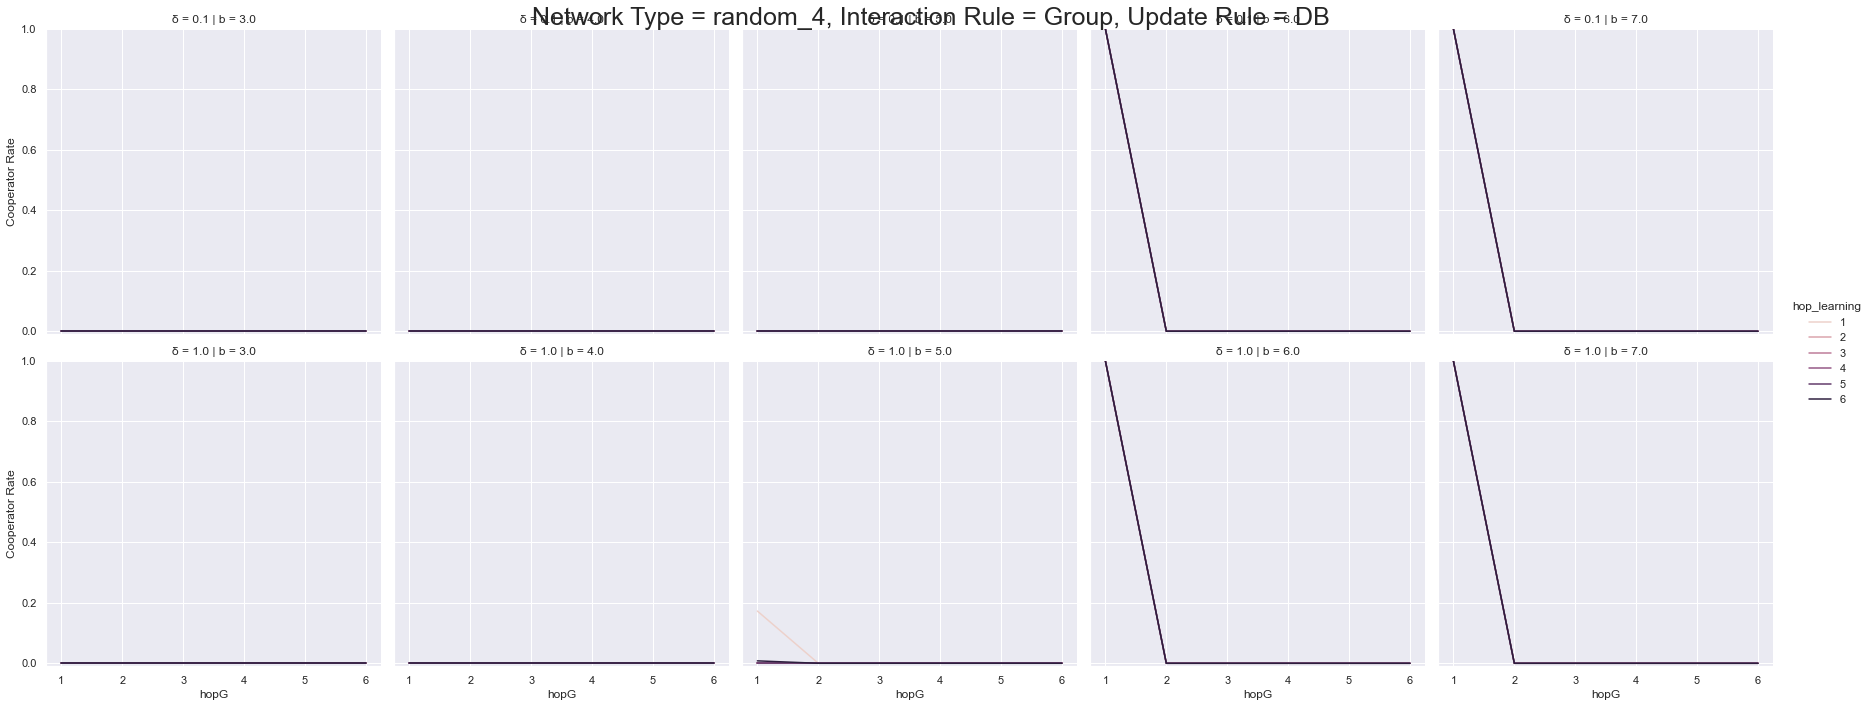

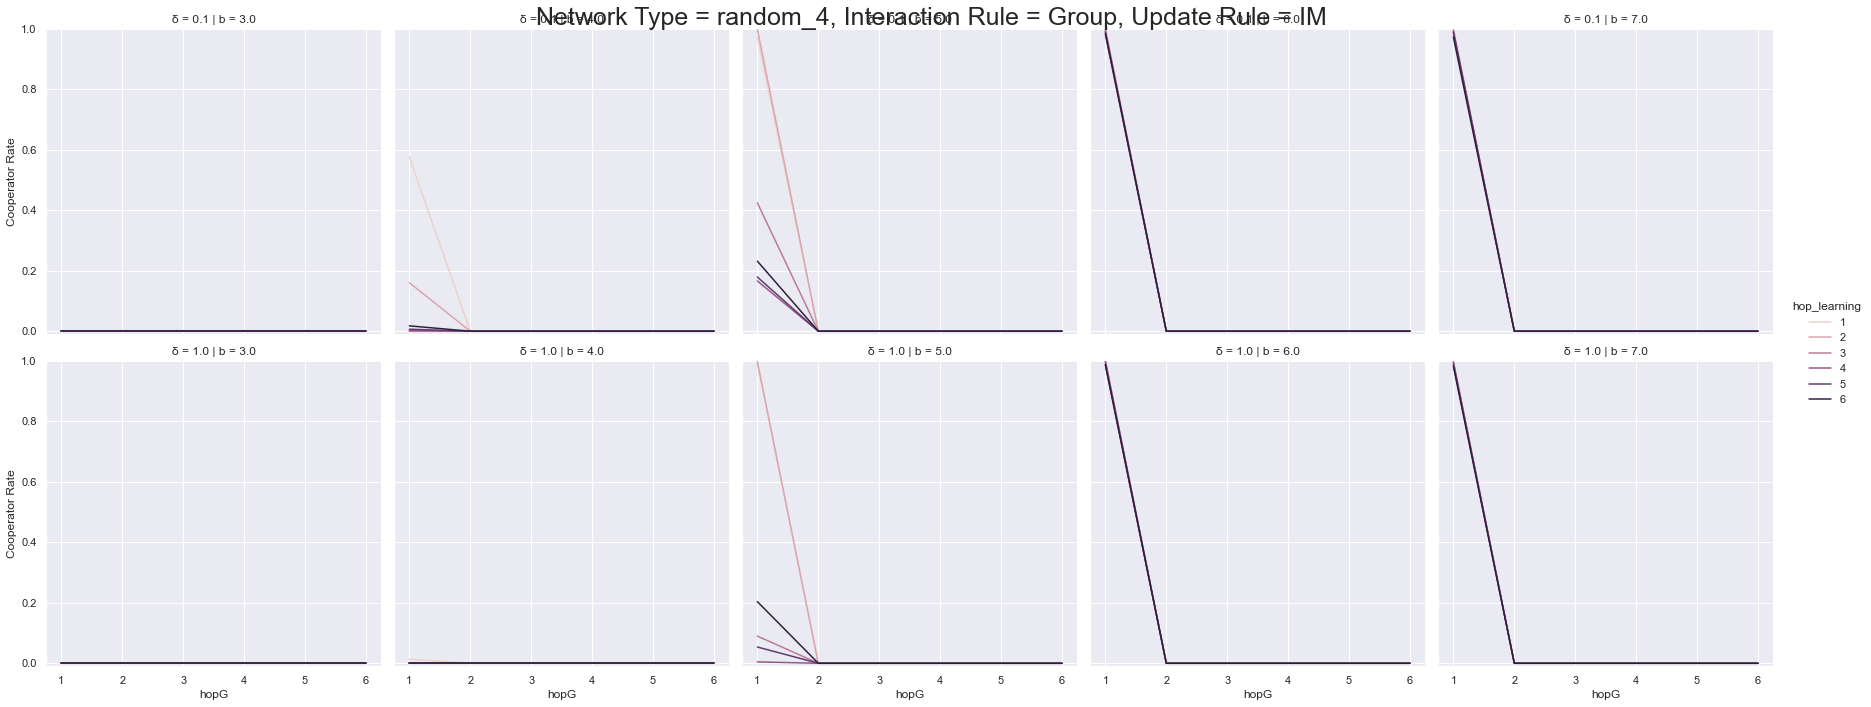

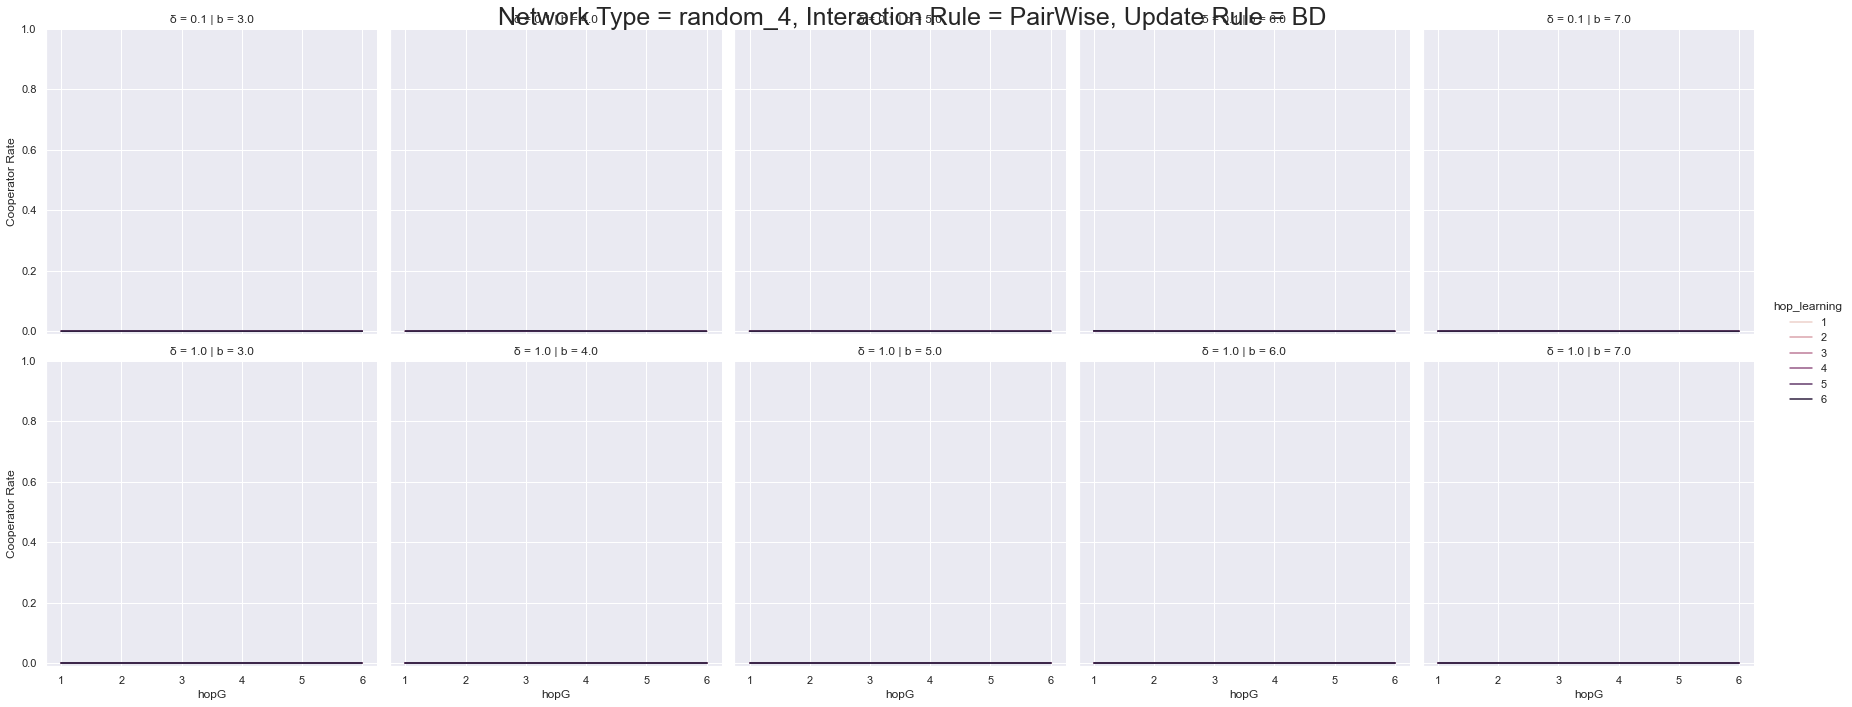

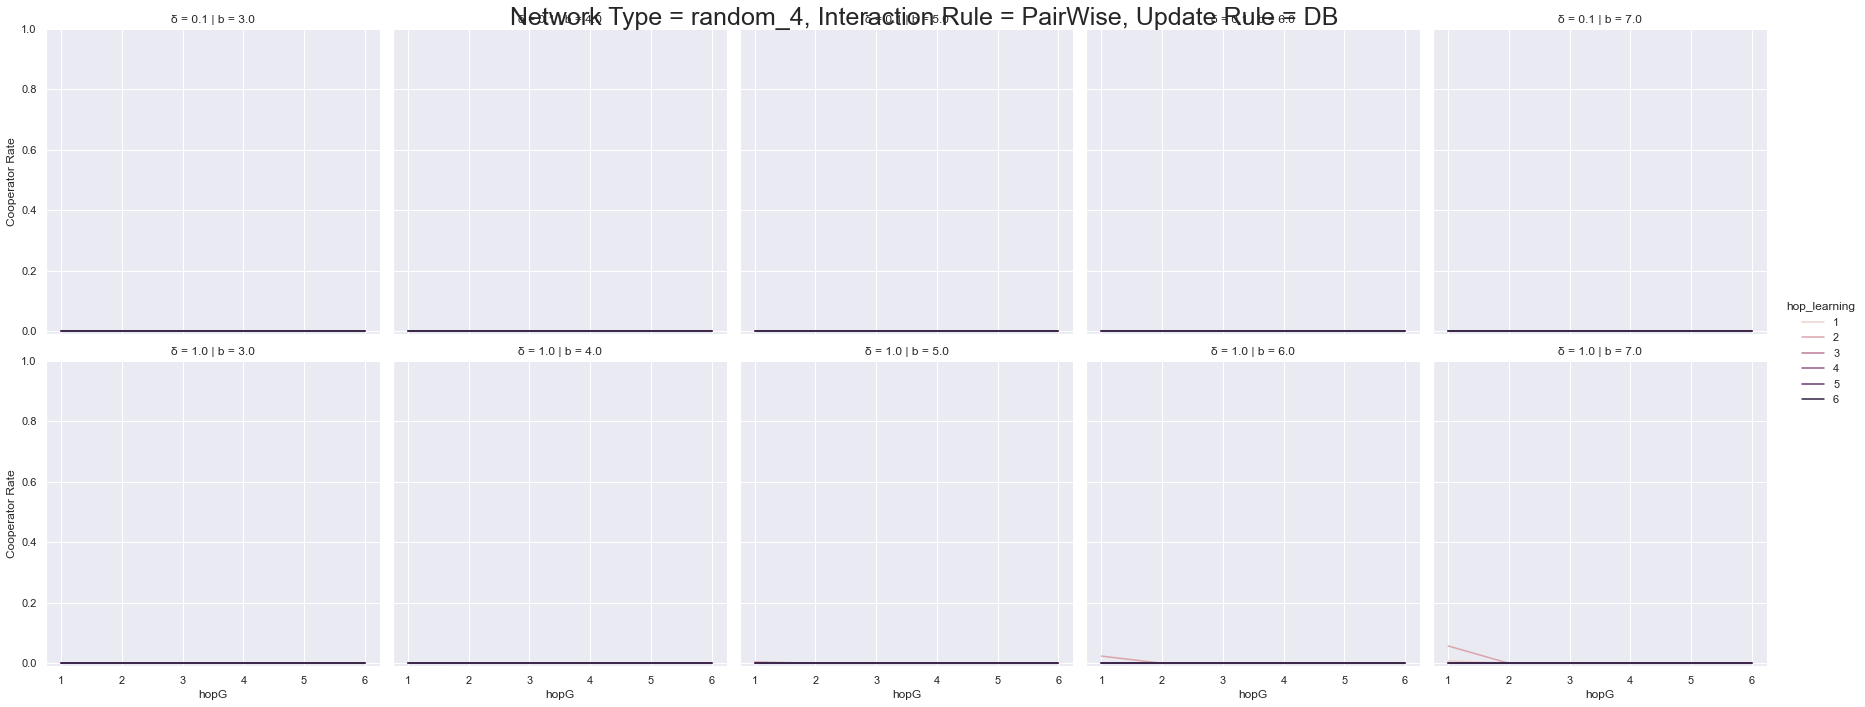

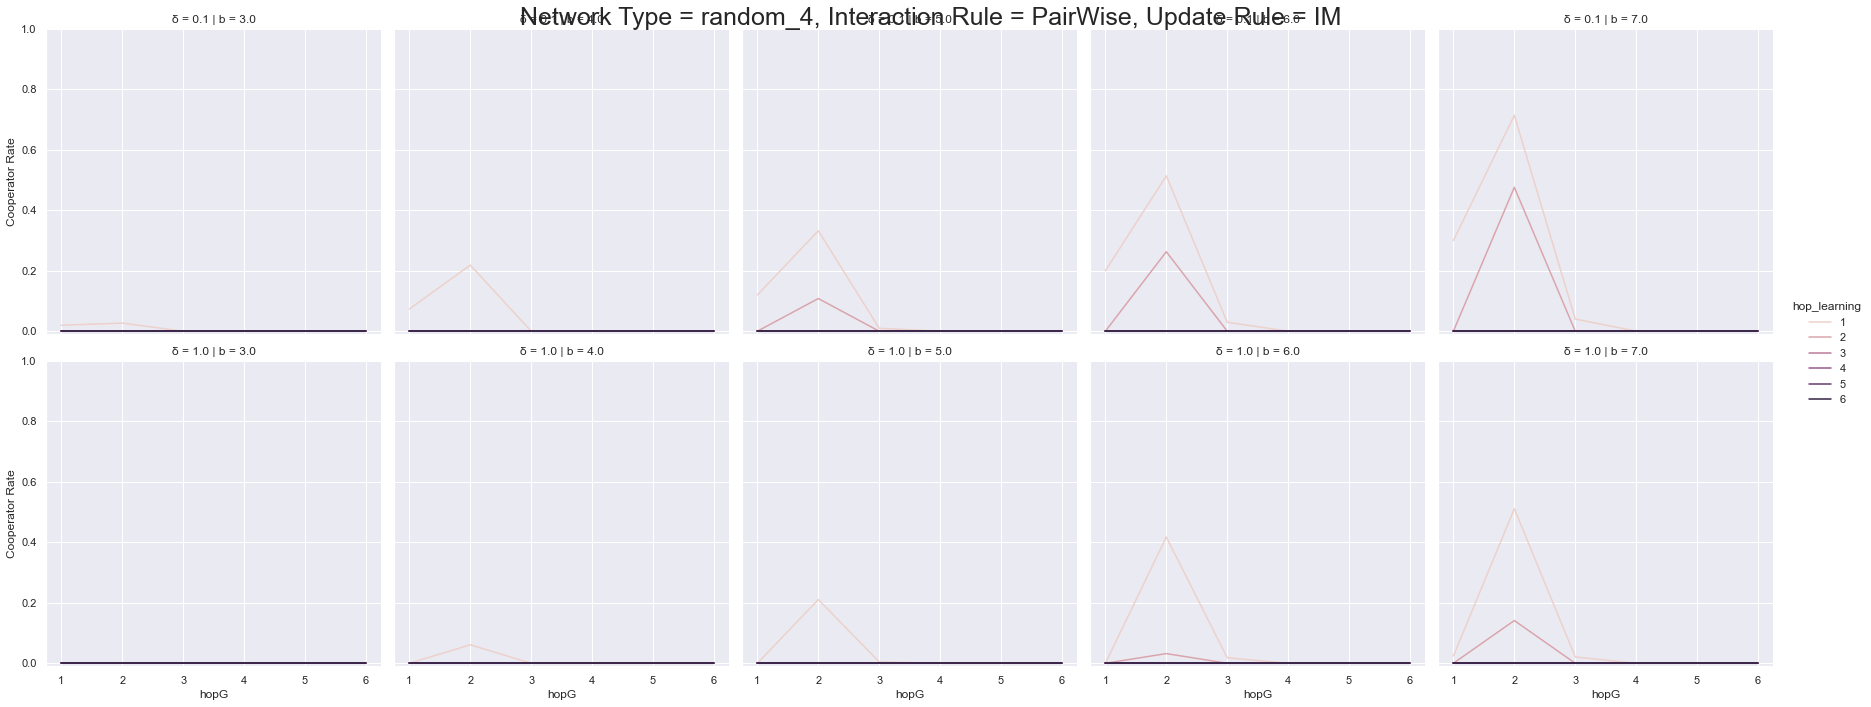

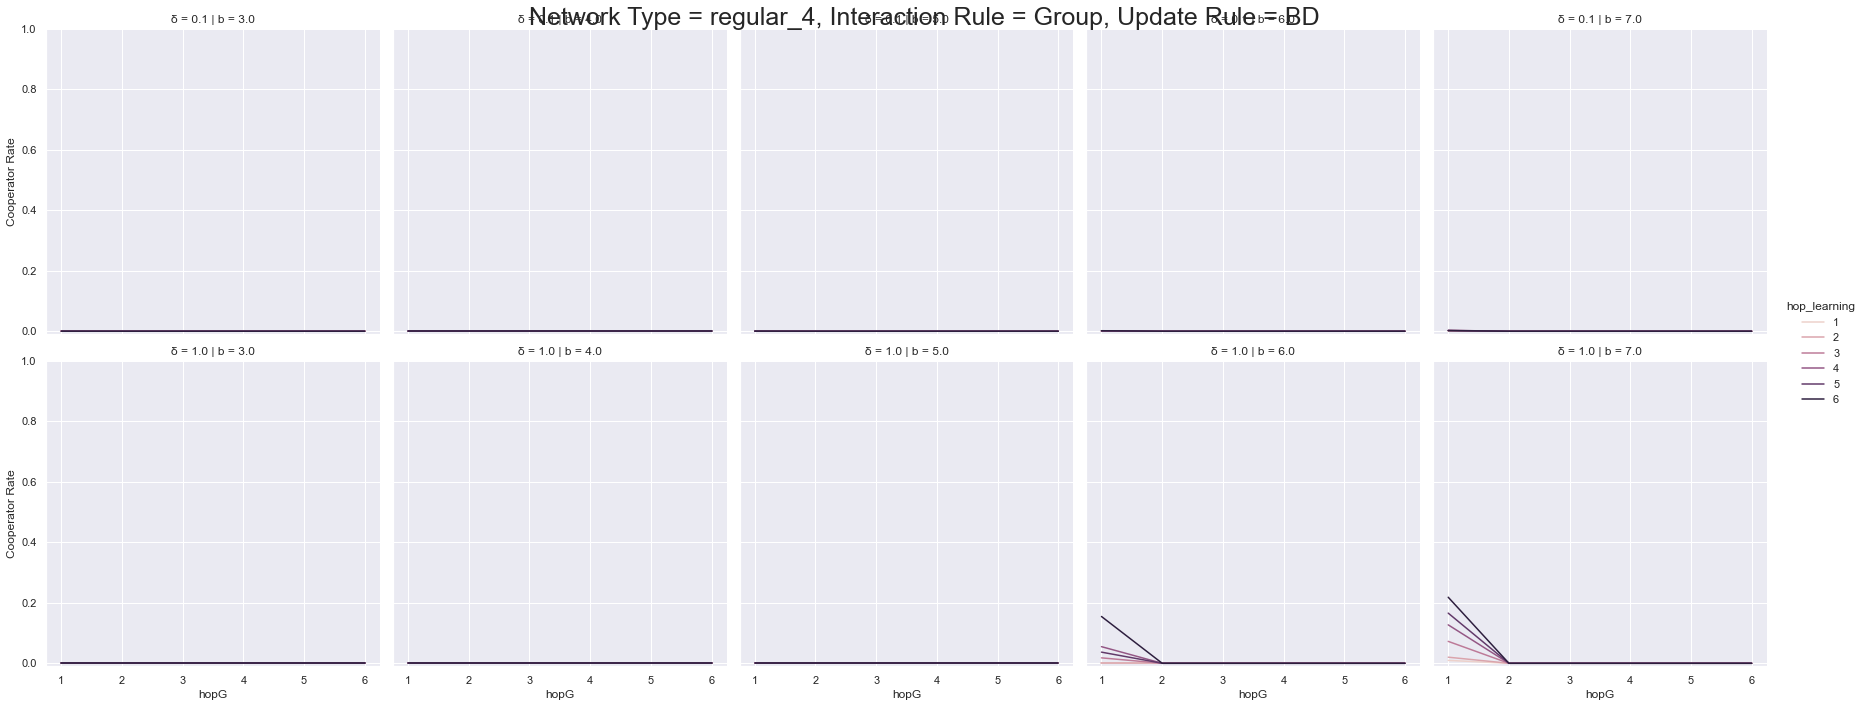

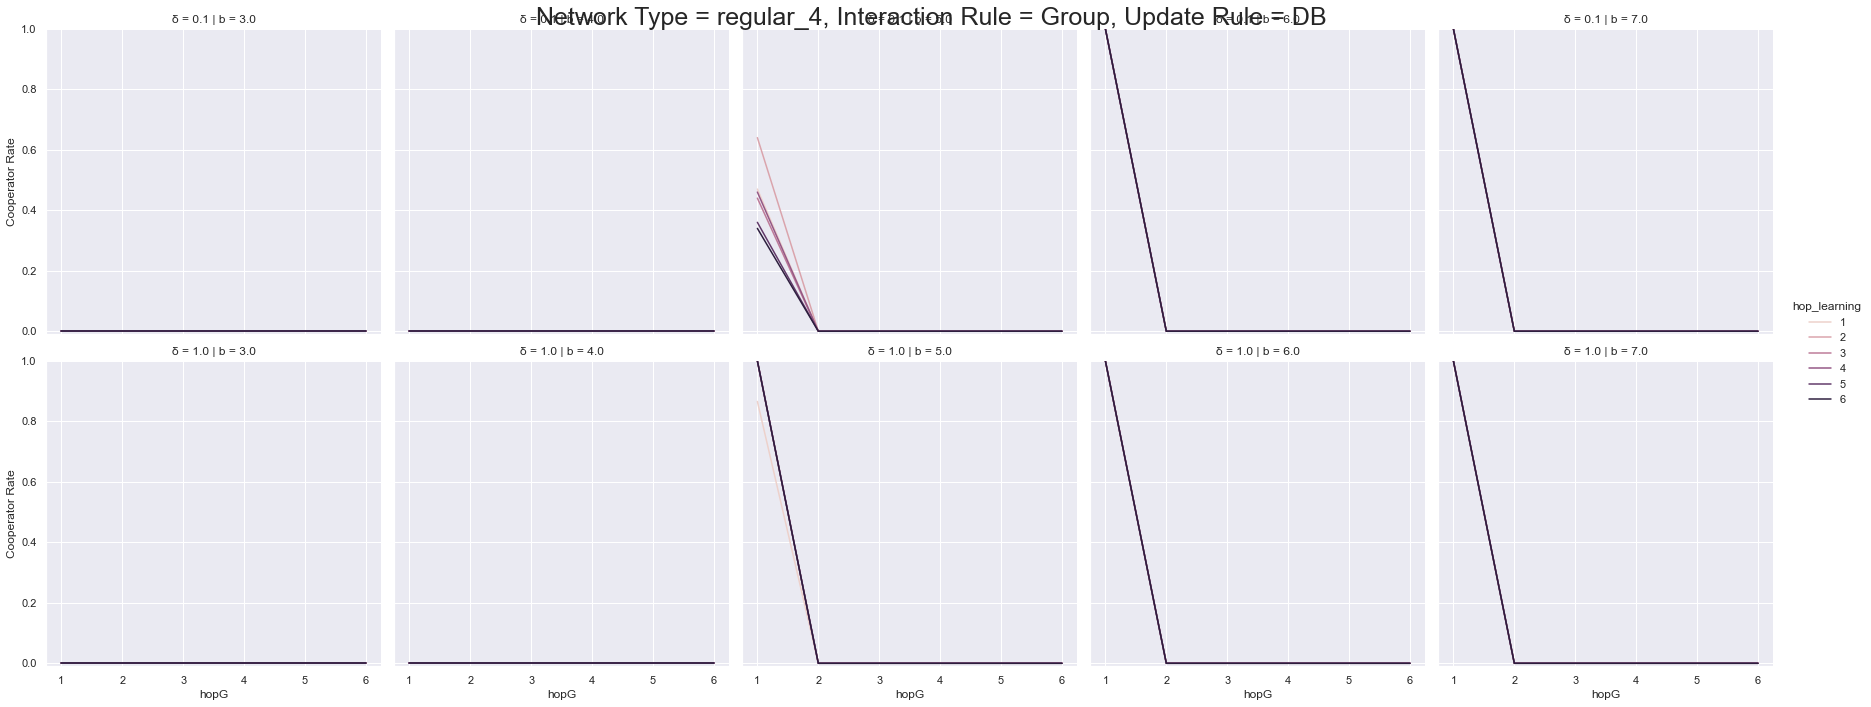

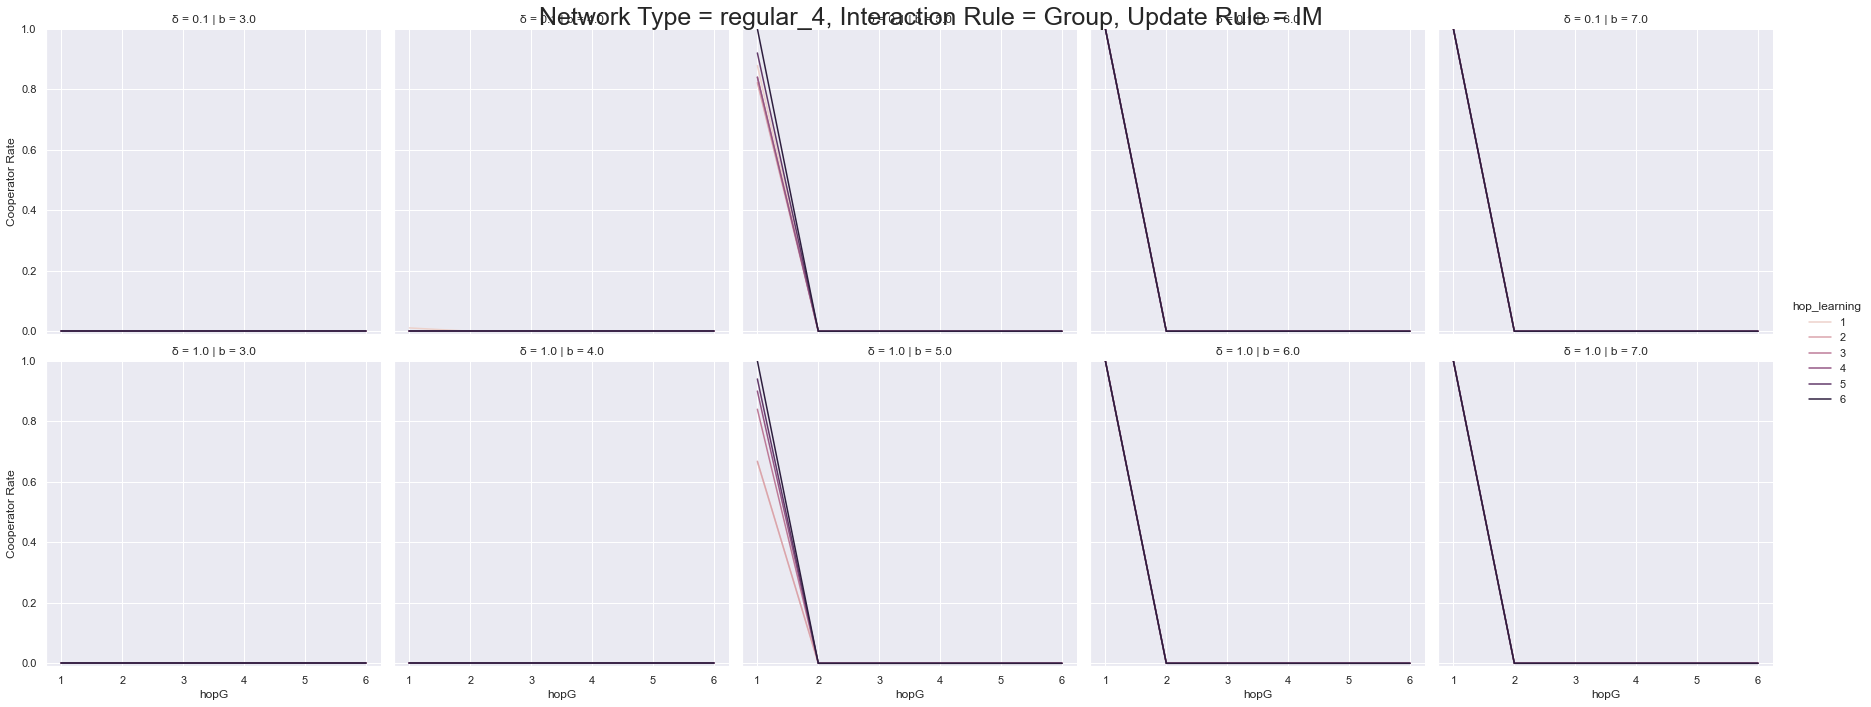

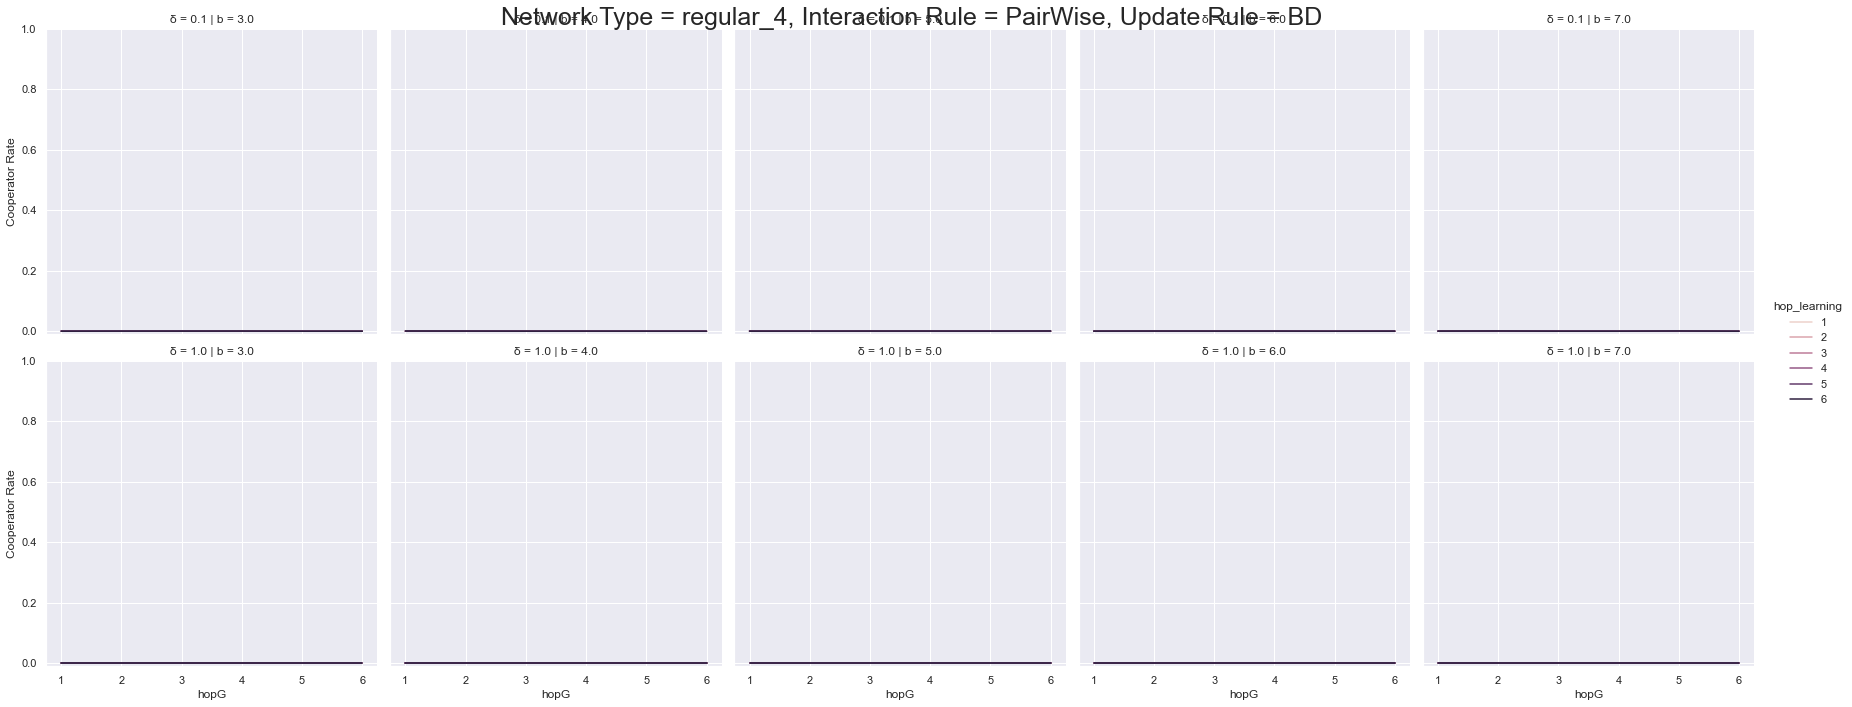

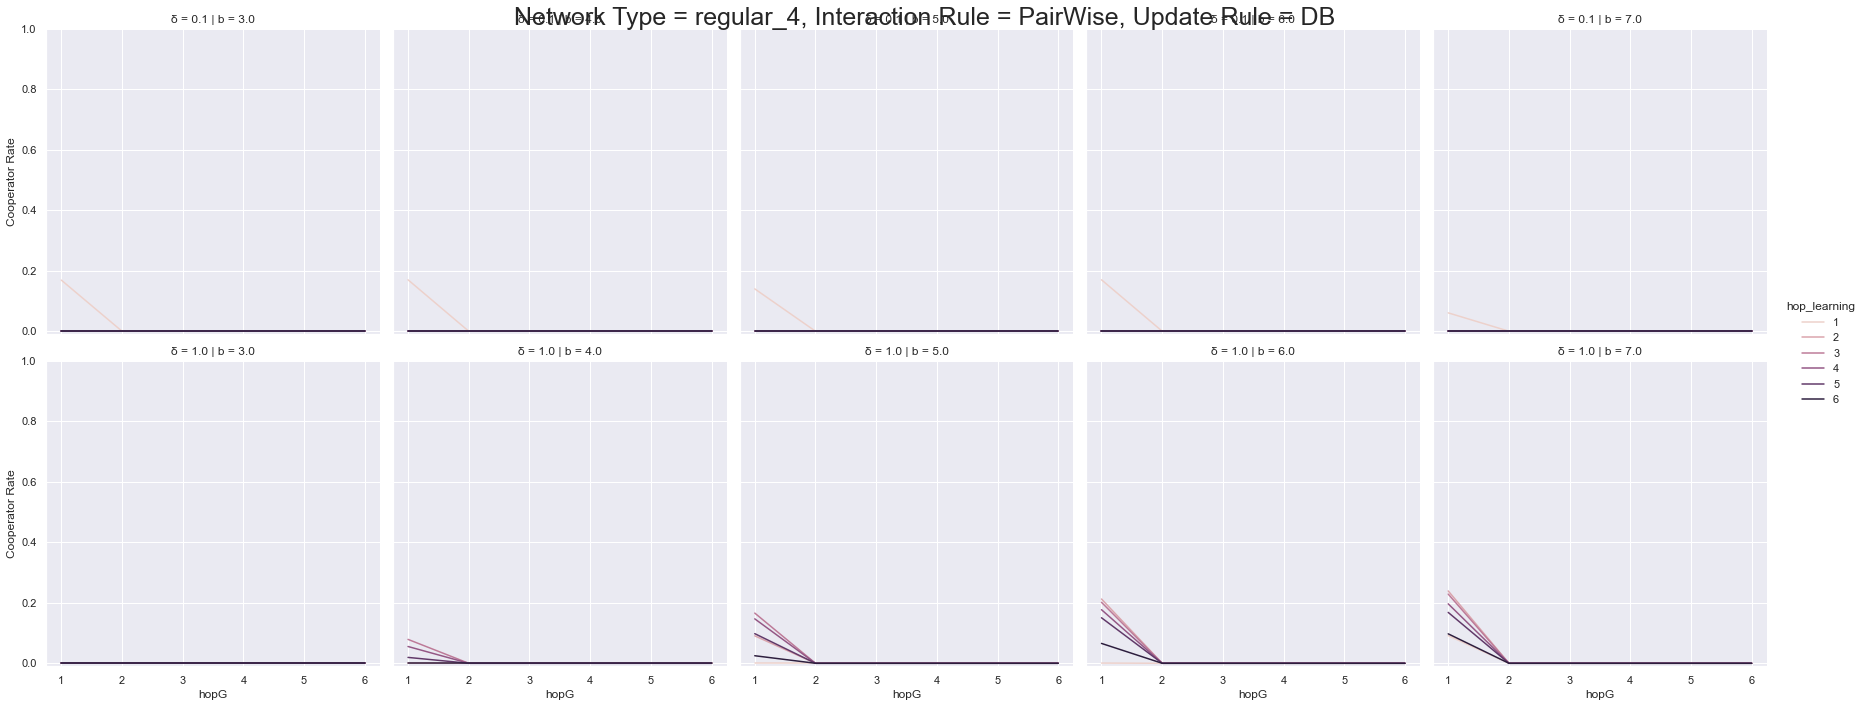

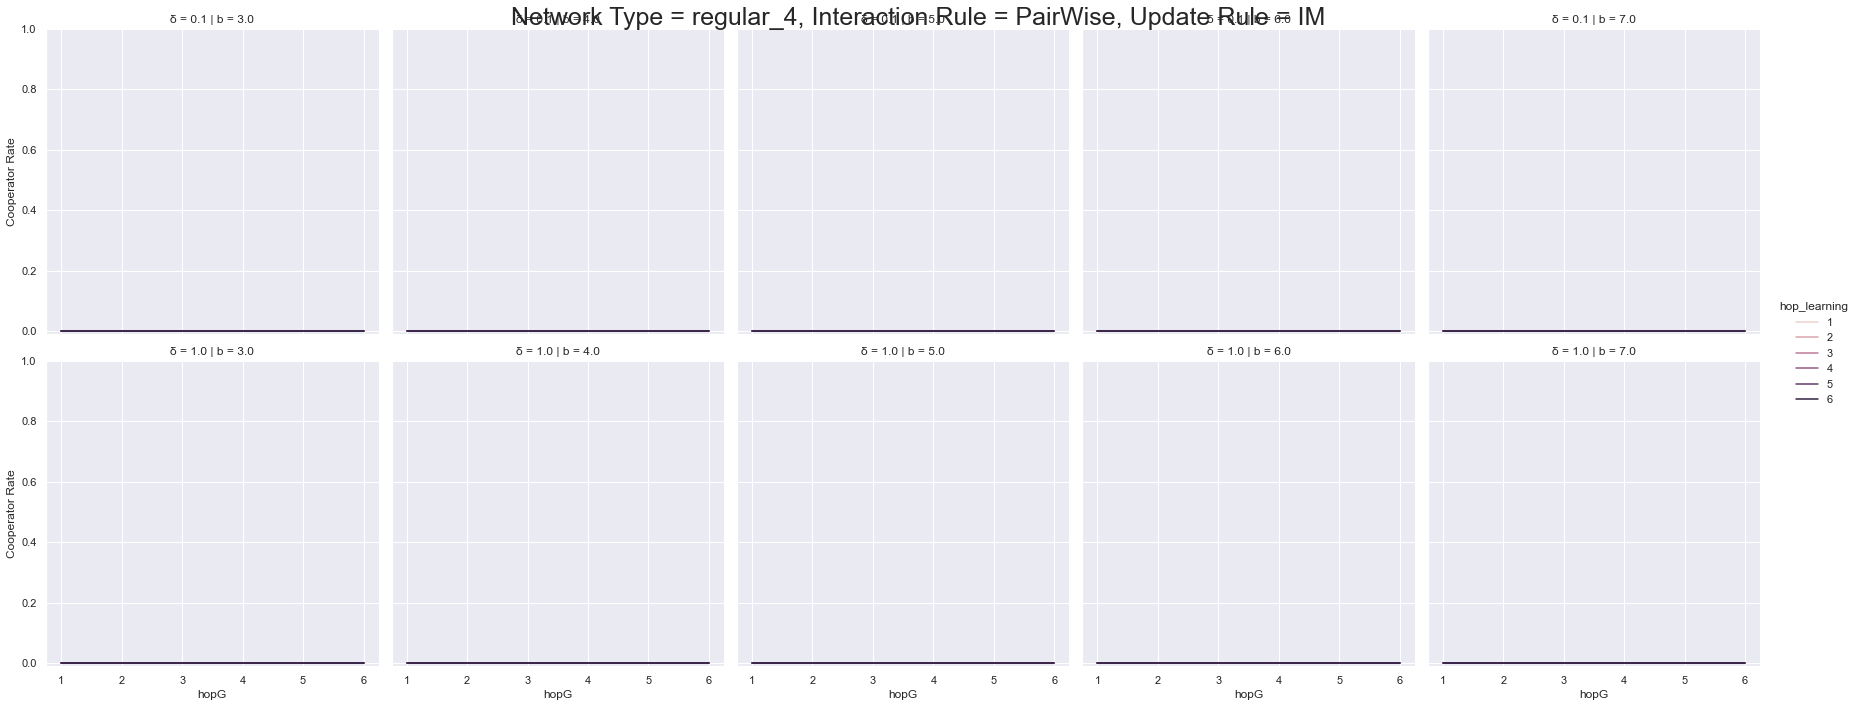

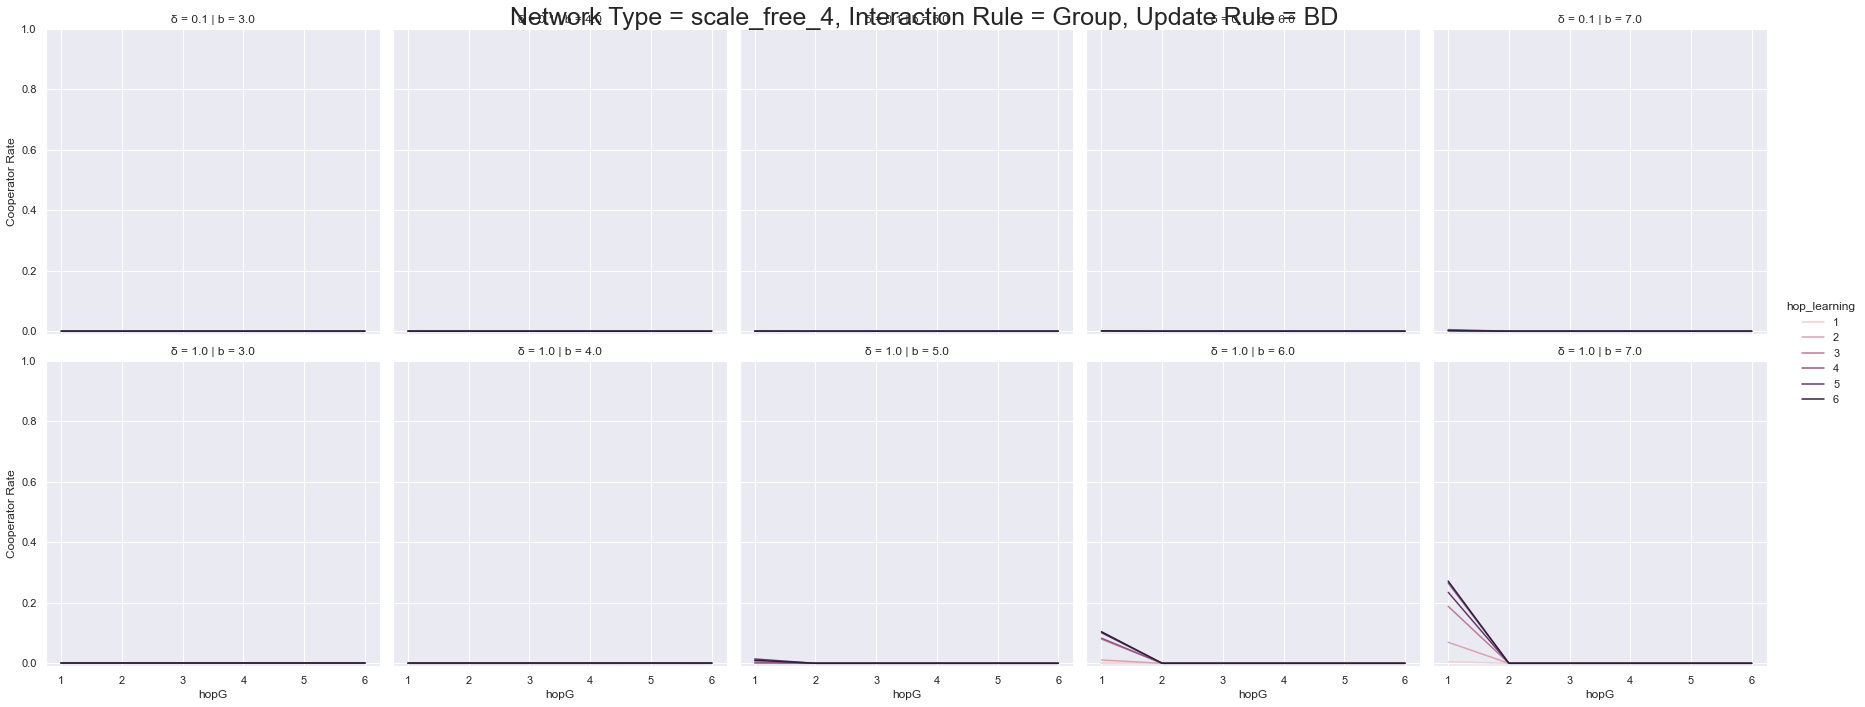

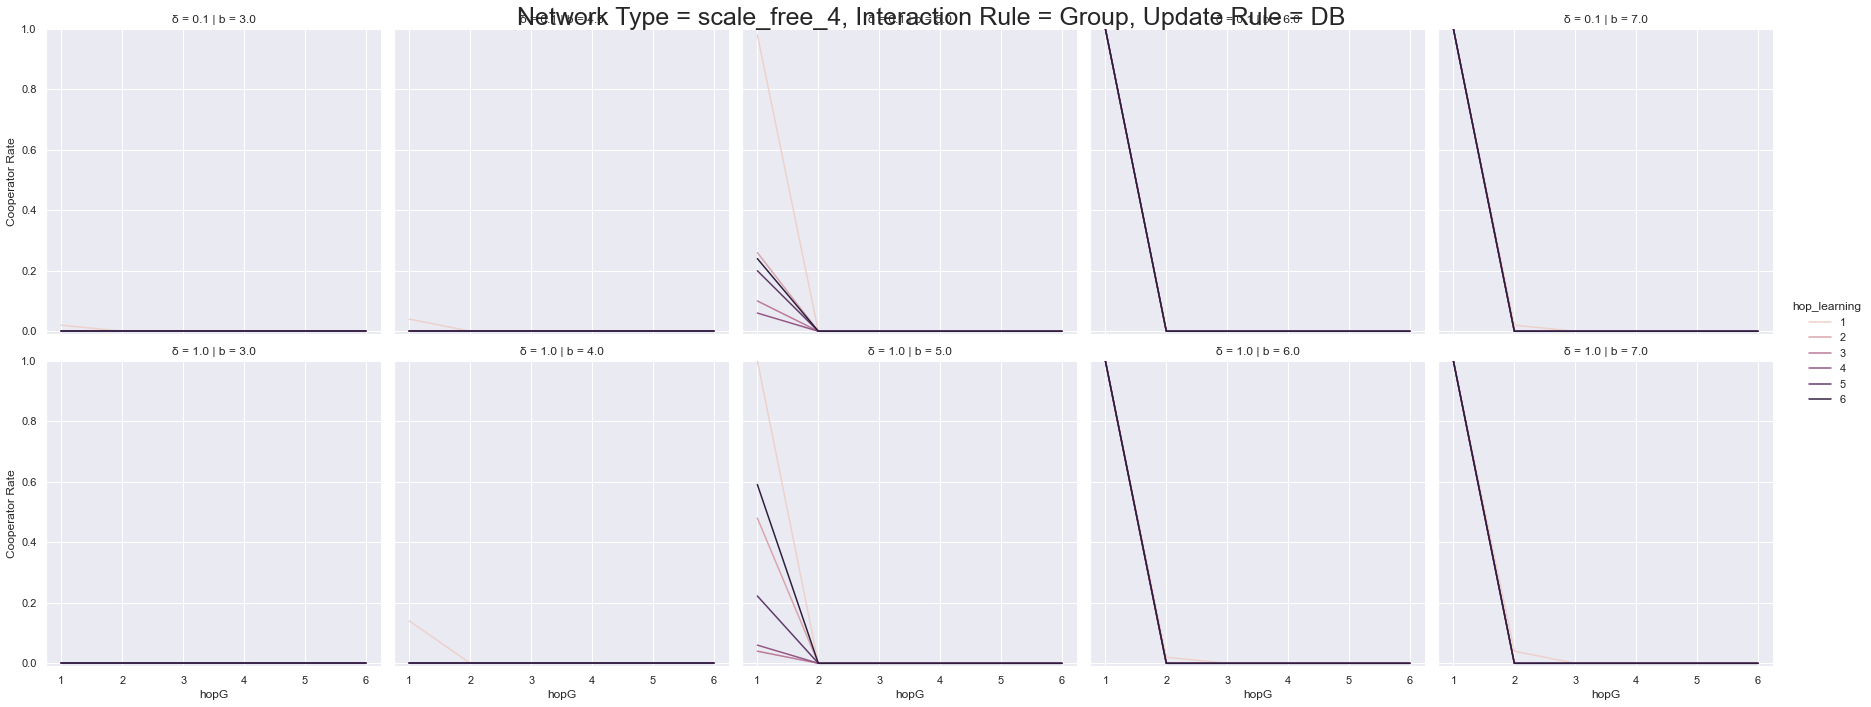

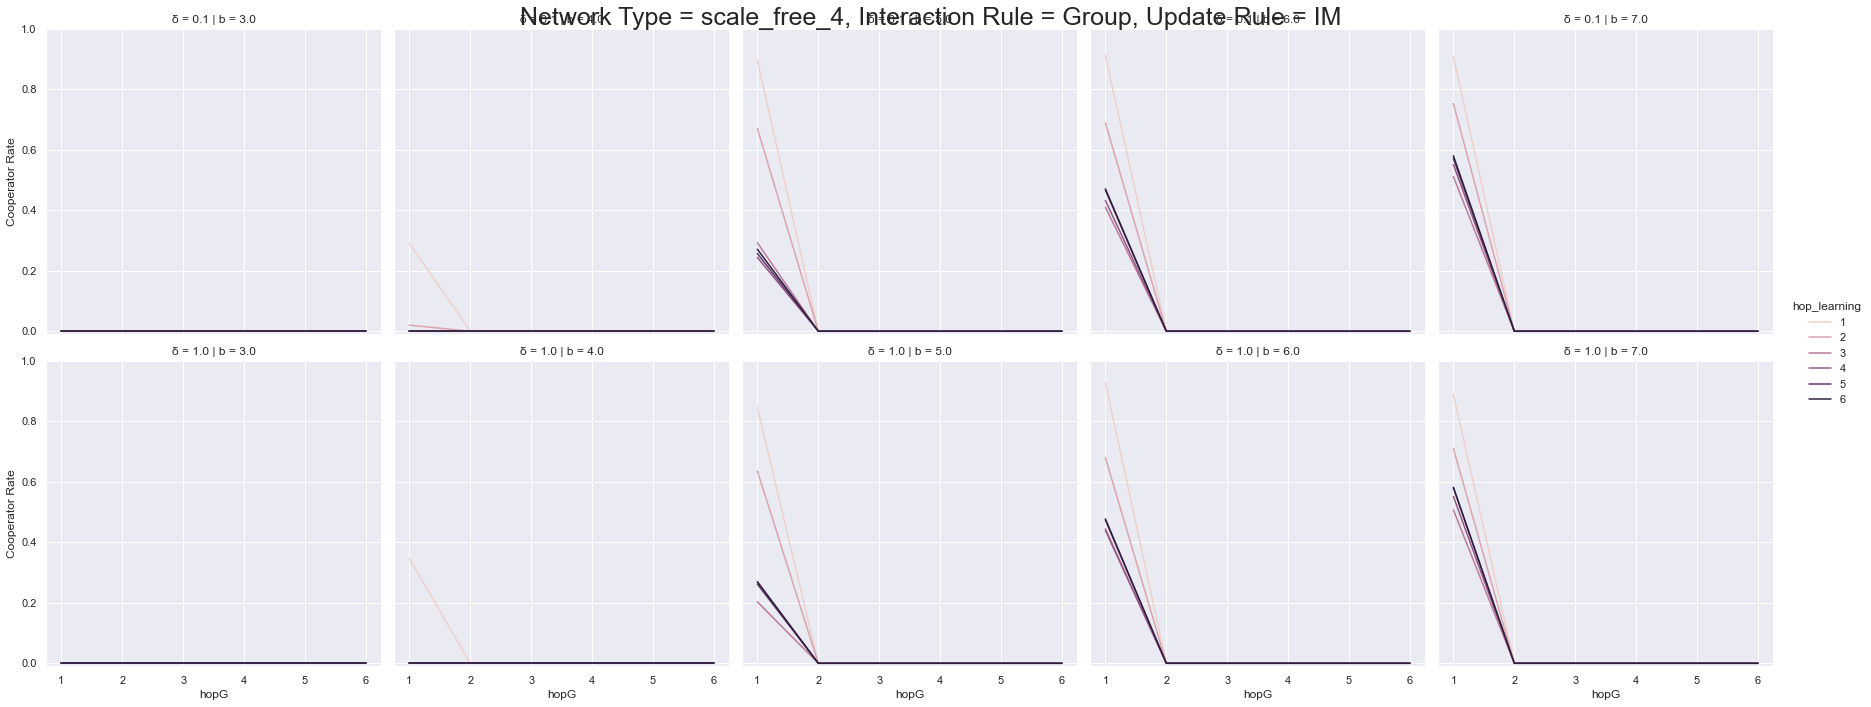

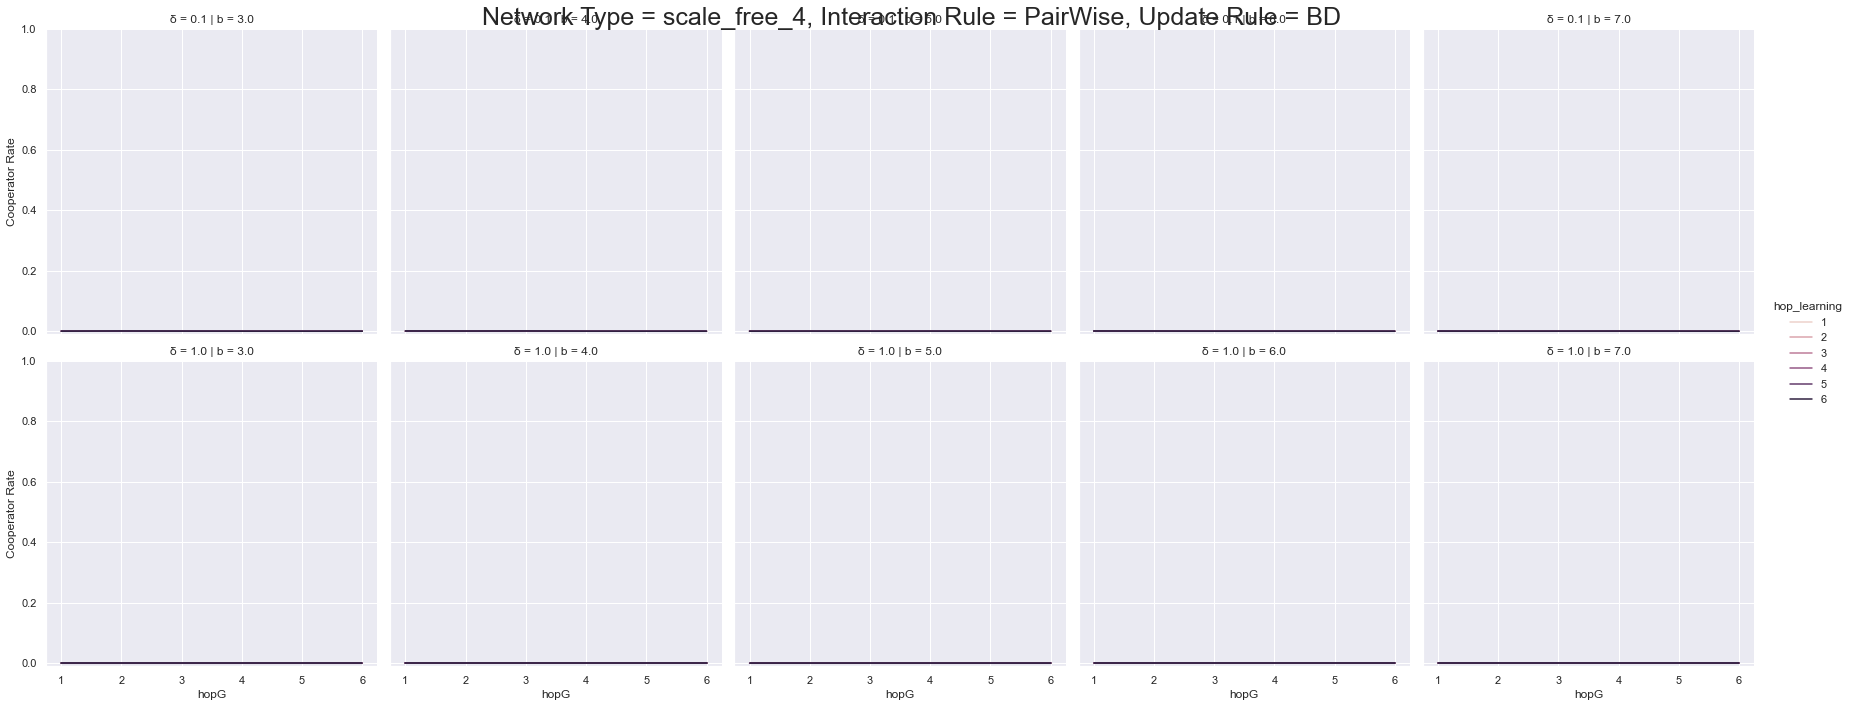

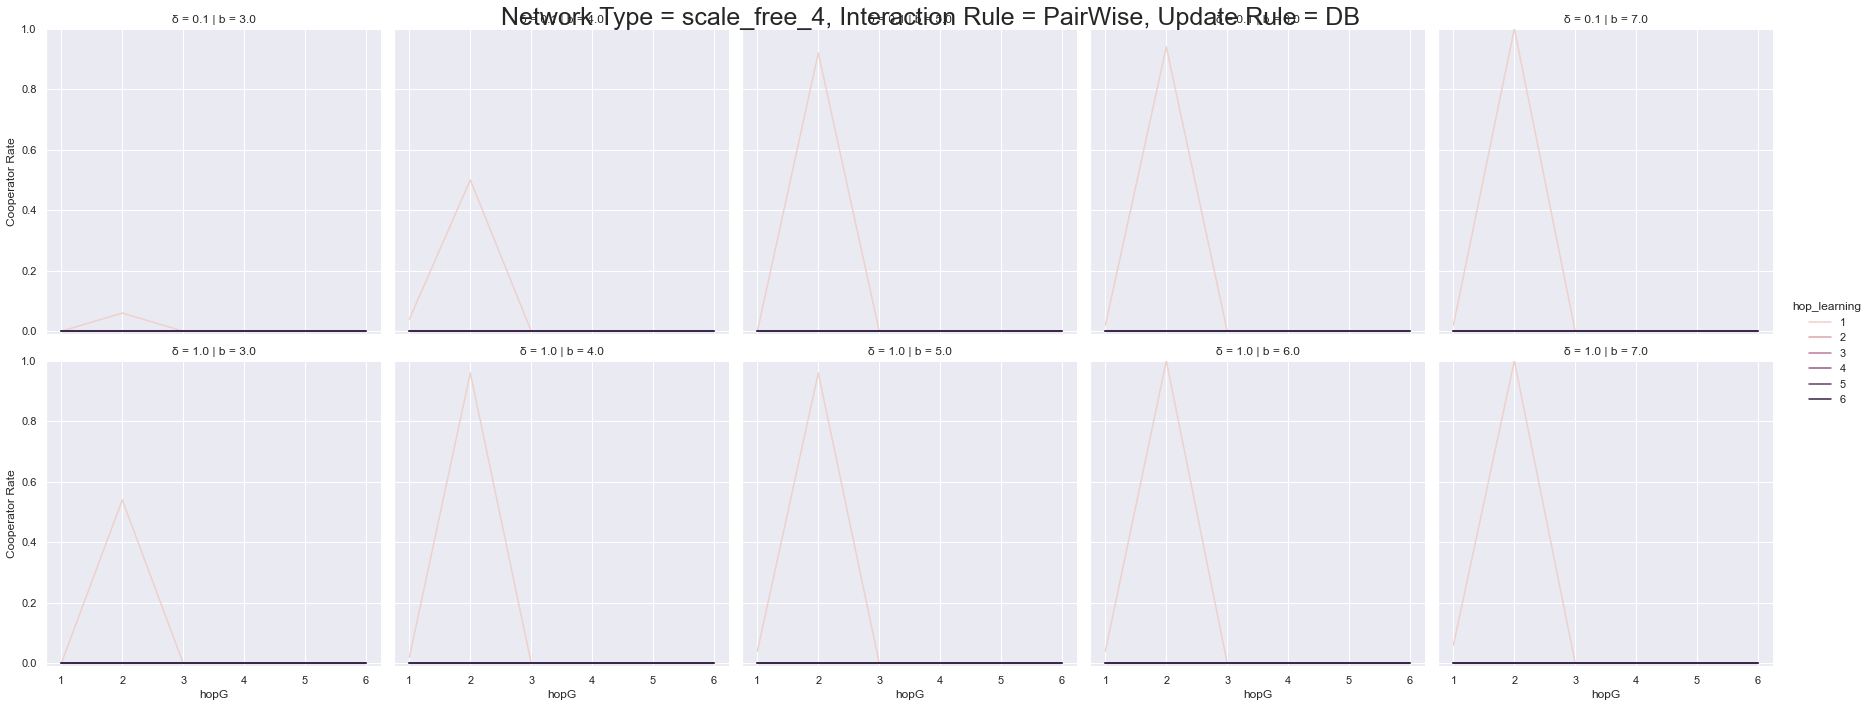

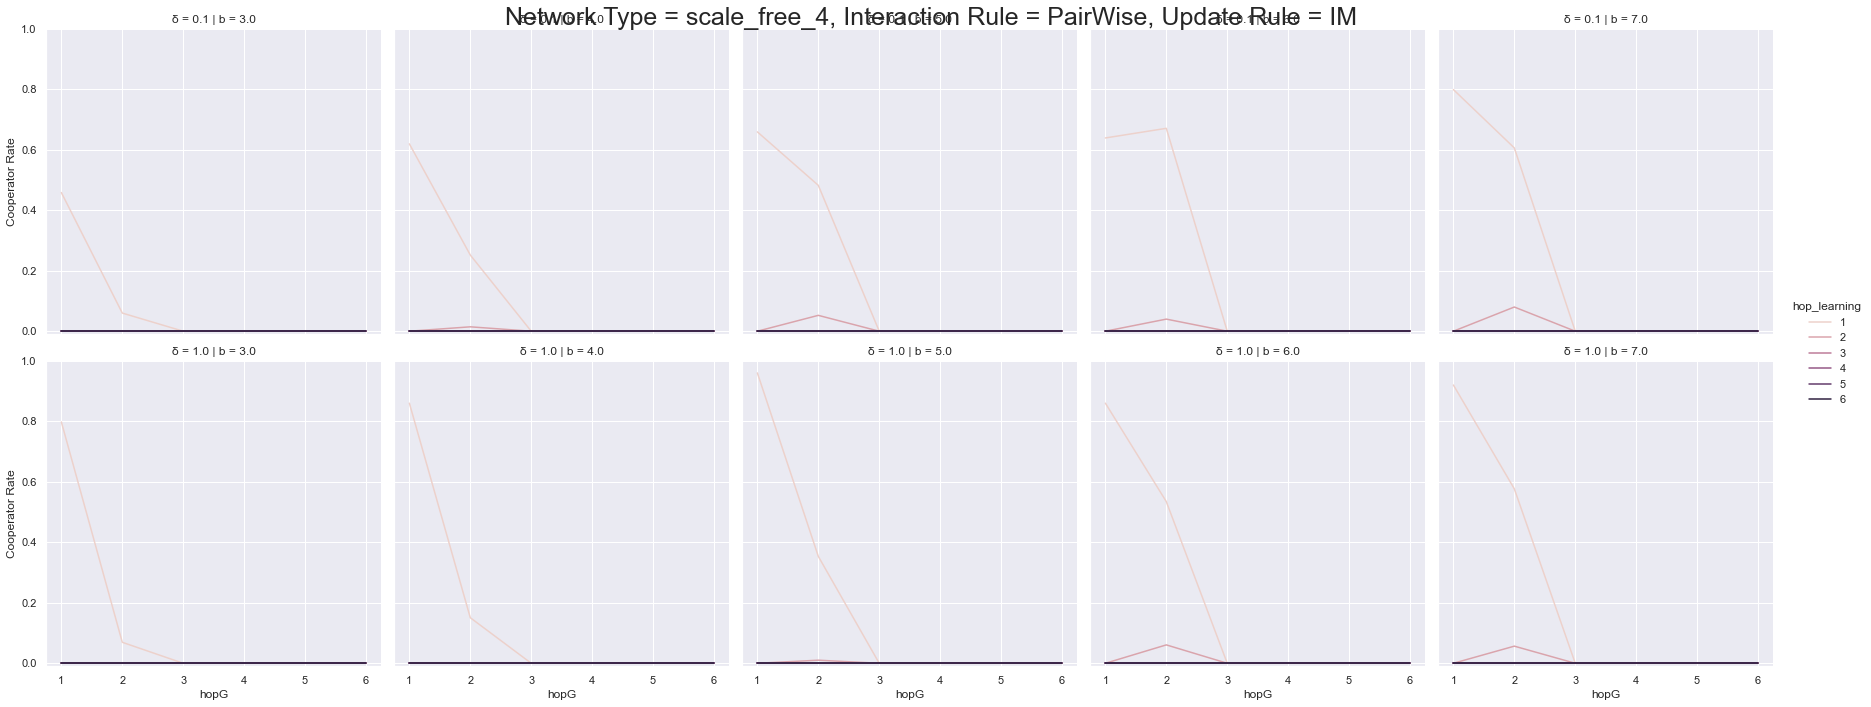

In [7]:
for (_, network_type, interaction_rule, update_rule) in df[['network_type', 'interaction_rule', 'update_rule']].drop_duplicates().itertuples():
    _df = df[(df.network_type == network_type) & (df.interaction_rule == interaction_rule) & (df.update_rule == update_rule)][[
        'hop_game', 'hop_learning', 'b', 'δ', 'cooperator_rate'
    ]].reset_index(drop=True)
    g = sns.relplot(kind='line', x='hop_game', y='cooperator_rate', hue='hop_learning', row='δ', col='b', data=_df)
    g.set_axis_labels('hopG', 'Cooperator Rate')
    g.fig.suptitle('Network Type = {}, Interaction Rule = {}, Update Rule = {}'.format(network_type, interaction_rule, update_rule), size=25)
    g.fig.subplots_adjust(top=.95)
    g.set(ylim=(-0.01, 1))